In [1]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

# Read Data

In [3]:
df_train = pd.read_csv("data/cmapss_train_df.csv")

In [4]:
X_train = pd.read_csv("data/cmapss_train_data.csv")
y_train = pd.read_csv("data/cmapss_train_labels.csv")
X_test = pd.read_csv("data/cmapss_test_data.csv")
y_test = pd.read_csv("data/cmapss_test_labels.csv")

# Data Preprocessing

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Save scaler to reuse on streaming test data later

In [6]:
scaler_filename = "./model/cmapss_scaler.save"
joblib.dump(scaler, scaler_filename) 

['./model/cmapss_scaler.save']

In [8]:
scaler.feature_names_in_

array(['cycle', '(LPC outlet temperature) (◦R)',
       '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)',
       '(bypass-duct pressure) (psia)', '(HPC outlet pressure) (psia)',
       '(Physical fan speed) (rpm)', '(Physical core speed) (rpm)',
       '(HPC outlet Static pressure) (psia)',
       '(Ratio of fuel flow to Ps30) (pps/psia)',
       '(Corrected fan speed) (rpm)', '(Bypass Ratio) ',
       '(Bleed Enthalpy)', '(High-pressure turbines Cool air flow)',
       '(Low-pressure turbines Cool air flow)'], dtype=object)

## Random Forest Regressor

In [9]:
rf_reg = RandomForestRegressor(n_estimators=500, min_samples_leaf=1, max_features='sqrt')
rf_reg.fit(X_train, y_train)

/Users/one/opt/anaconda3/envs/py3912/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features='sqrt', n_estimators=500)

In [10]:
y_preds = rf_reg.predict(X_test)

In [11]:
rf_reg.score(X_test,y_test)

0.8088716236825293

In [12]:
mean_squared_error(y_test, y_preds, squared=False)

18.167382386023586

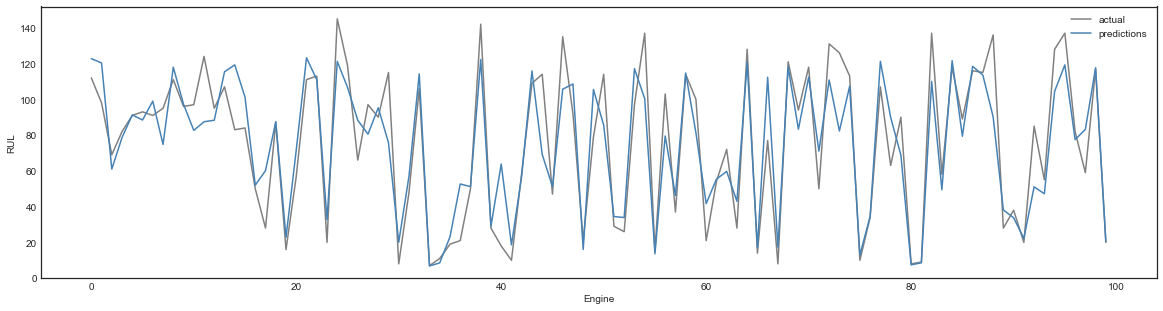

In [13]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 20,5 

fig,ax = plt.subplots()

plt.ylabel('RUL')
plt.xlabel('Engine')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())), y = y_test.to_numpy().ravel(),
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_preds,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

In [14]:
## Defining function to plot real data and the predicted one to make some comparison.

def plot_predActual(y_test, y_pred):

    indices = np.arange(len(y_pred))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_pred)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

/var/folders/nm/wc9k6y9s09g8gmxp1y7whfdr0000gn/T/ipykernel_19631/1674339914.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_values = [int(x) for x in y_test.values]


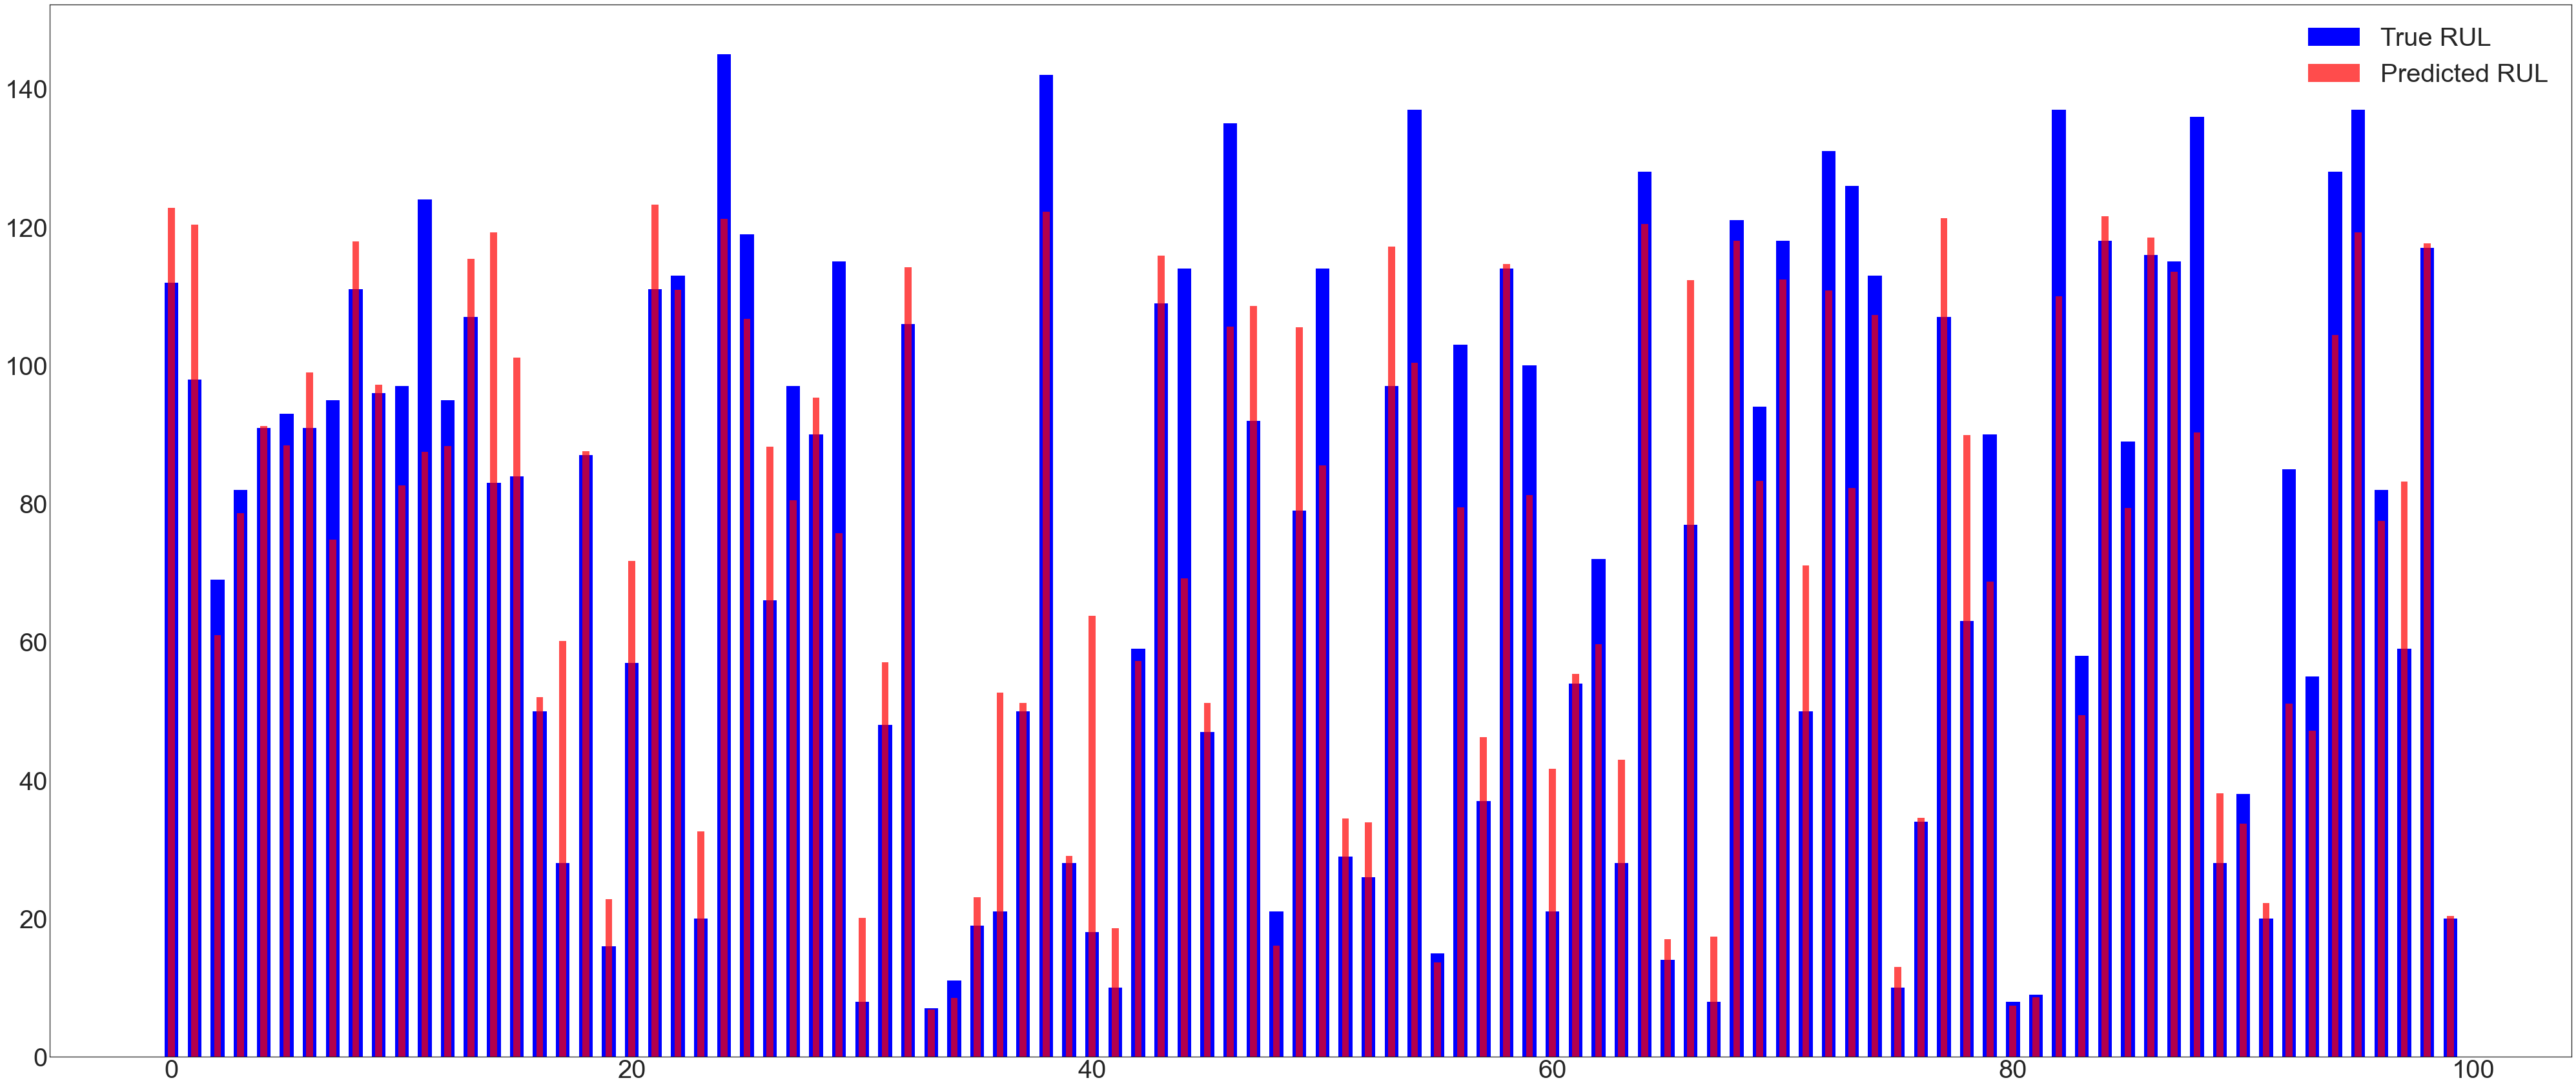

In [15]:
plot_predActual(y_test, y_preds)

In [16]:
y_preds

array([122.752, 120.34 ,  61.   ,  78.674,  91.256,  88.434,  98.976,
        74.766, 117.968,  97.26 ,  82.634,  87.466,  88.322, 115.412,
       119.242, 101.172,  51.998,  60.142,  87.562,  22.848,  71.726,
       123.238, 110.962,  32.64 , 121.196, 106.718,  88.296,  80.514,
        95.31 ,  75.708,  20.078,  57.084, 114.244,   6.83 ,   8.532,
        23.094,  52.668,  51.2  , 122.256,  29.068,  63.828,  18.606,
        57.24 , 115.85 ,  69.192,  51.202, 105.656, 108.566,  16.05 ,
       105.486,  85.508,  34.448,  33.89 , 117.184, 100.378,  13.656,
        79.494,  46.26 , 114.68 ,  81.23 ,  41.672,  55.352,  59.702,
        42.974, 120.484,  17.056, 112.354,  17.366, 117.996,  83.28 ,
       112.388,  71.03 , 110.82 ,  82.306, 107.306,  12.982,  34.608,
       121.258,  89.922,  68.758,   7.444,   8.594, 110.02 ,  49.42 ,
       121.618,  79.384, 118.458, 113.532,  90.266,  38.148,  33.772,
        22.218,  51.08 ,  47.188, 104.442, 119.274,  77.486,  83.176,
       117.676,  20.

### Save the model to disk

In [ ]:
pickle.dump(rf_reg, open("baseline_rf_reg_v2.pkl", 'wb'))

In [ ]:
X_test[-1]

In [ ]:
a = X_test[-1]


In [ ]:
rf_reg.predict([a])

In [ ]:
y_test